This notebook is intended to test the performance of various models on the validation 
dataset to give a comparitive understanding

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
from tensorboardX import SummaryWriter

### Initial Performace is computed against the F2F dataset and then we try it against the DeepFake dataset

In [2]:
# for CRNN
class Dataset_CRNN_Deep_Fake(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, data_path, frame_length=10, transform=None):
        "Initialization"
        self.transform = transform
        #self.frames = frames
        self.folders = data_path
        self.frames = frame_length #For our case since we are computing 10 frames always

    def __len__(self):
        "Denotes the total number of samples"
        return len(os.listdir(self.folders))

    def read_images(self, data_path, use_transform):
        X = []
        file_name = ""
        for i in os.listdir(data_path):
            file_name = i
            image = Image.open(os.path.join(data_path,i))
            
            #print(image.shape)
            if use_transform is not None:
                image = use_transform(image)
                #print(image.size)
            image = torch.from_numpy(np.asarray(image))
            X.append(image)
        X = torch.stack(X, dim=0)

        return X, file_name

    def __getitem__(self, index):
        data_path = os.path.join(self.folders,os.listdir(self.folders)[index])
              
        # Load data
        X, file_name = self.read_images(data_path, self.transform)                     # (input) spatial images
        
        y = np.ones(self.frames)
        if 'real' in data_path:
            y = np.zeros(self.frames)
        #print("Folder is {}".format(data_path))
        #print(X.shape)
        return X, torch.from_numpy(y).type(torch.LongTensor)

## Including F2F dataloader

In [3]:
# for CRNN
class Dataset_CRNN_F2F(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, data_path, transform=None):
        "Initialization"
        self.transform = transform
        #self.frames = frames
        self.folders = data_path
        self.frames = 10 #For our case since we are computing 10 frames always

    def __len__(self):
        "Denotes the total number of samples"
        return len(os.listdir(self.folders))

    def read_images(self, data_path, use_transform):
        X = []
        for i in os.listdir(data_path):
            #print("file name is ",i)
            image = Image.open(os.path.join(data_path,i))
            
            #print(image.shape)
            if use_transform is not None:
                image = use_transform(image)
                #print(image.size)
            image = torch.from_numpy(np.asarray(image))
            X.append(image)
        X = torch.stack(X, dim=0)

        return X

    def __getitem__(self, index):
        data_path = os.path.join(self.folders,os.listdir(self.folders)[index])
              
        # Load data
        X = self.read_images(data_path, self.transform)                     # (input) spatial images
        
        y = np.ones(self.frames)
        if 'orig' in data_path:
            y = np.zeros(self.frames)
        # print(X.shape)
        return X, torch.from_numpy(y).type(torch.LongTensor)  #torch.from_numpy(y).type(torch.LongTensor) 

In [4]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(256),
    #transforms.ToTensor()
    #transforms.Normalize(mean=[0.4246, 0.4144, 0.4114],
                         #std=[0.2265, 0.2208, 0.2215])
    ])

In [5]:
val_path = '/home/chinmay/datatset/val/'
val_data = Dataset_CRNN_F2F(val_path, transform=TRANSFORM_IMG)

In [6]:
batch_size = 16

In [7]:
CNN_emded_dim = 32768

res_size = 224        # ResNet image size
dropout_p = 0.5      # dropout probability being high as it seems to overfit

# use same decoder RNN saved!
RNN_hidden_layers = 2
RNN_hidden_nodes = 64
RNN_FC_dim = 16

In [8]:
# 2D CNN encoder using ResNet-152 pretrained
import torchvision.models as models
class ResCNNEncoder(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(ResCNNEncoder, self).__init__()

        # self.model = Meso4_modified()
        self.model = models.vgg11_bn(pretrained=True)
        
    def forward(self, x_3d):
        x_3d = x_3d.permute(0,1,4,2,3)# Required to match shapes
        x_3d = x_3d.type(torch.cuda.FloatTensor) #Converting to Float Tensor from Byte Tensor
        cnn_embed_seq = []
        with torch.no_grad():
            for t in range(x_3d.size(1)):
                x = self.model.features(x_3d[:, t, :, :, :])
                x = x.view(x.shape[0], -1)
                cnn_embed_seq.append(x)
            cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)
            #print("shaps is {}".format(cnn_embed_seq.shape))
        return cnn_embed_seq


class DecoderRNN(nn.Module):
    def __init__(self, CNN_embed_dim=256, h_RNN_layers=3, h_RNN=256, h_FC_dim=128, drop_p=0.3, num_classes=2):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = CNN_embed_dim
        self.h_RNN_layers = h_RNN_layers   # RNN hidden layers
        self.h_RNN = h_RNN                 # RNN hidden nodes
        self.h_FC_dim = h_FC_dim
        self.drop_p = drop_p
        self.num_classes = num_classes

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,        
            num_layers=h_RNN_layers, 
            dropout = drop_p,
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)

    def forward(self, x_RNN):
        
        self.LSTM.flatten_parameters()
        RNN_out, (h_n, h_c) = self.LSTM(x_RNN, None)  
        """ h_n shape (n_layers, batch, hidden_size), h_c shape (n_layers, batch, hidden_size) """ 
        """ None represents zero initial hidden state. RNN_out has shape=(batch, time_step, output_size) """
        # print("shape is {}".format(RNN_out.shape))
        # FC layers
        x = self.fc1(RNN_out[:, -1, :])   # choose RNN_out at the last time step
        x = F.relu(x)
        x = F.dropout(x, p=self.drop_p) #, training=self.training
        x = self.fc2(x)
        #print("output shape is {}".format(x.shape))
        return x

## ---------------------- end of CRNN module ---------------------- ##

In [7]:
def find_median(numpy_array = []): #This is expected to take an array of array. So,
    #print("Input array is {}".format(numpy_array))
    output = []
    confidence_scores = []
    for array in numpy_array:
        counts = np.bincount(array)
        output.append(np.argmax(counts))
        # Let us compute the confidence of the scores
        # since frames are independent, our confidence is purely based on the number
        # of frames our model thinks is belonging to a specific category
        # the confidence of individual frame prediction is not taken into consideration
        # and this portion is debatable....
        frame_set_pred = np.sort(counts)[-1]
        confidence = frame_set_pred/sum(counts)
        confidence_scores.append(confidence)
    return torch.from_numpy(np.asarray(output)).type(torch.LongTensor), torch.from_numpy(np.asarray(confidence_scores)).type(torch.FloatTensor)

In [8]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")  
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
loss_function = nn.CrossEntropyLoss()
valid_loader = data.DataLoader(val_data, **params)

In [11]:
# reload CRNN model
cnn_encoder = ResCNNEncoder().to(device) #Since we have a GPU already
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_emded_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=2).to(device)

In [16]:
model_path = "/home/chinmay/model_weights/res_vgg/"
model_name_encoder = "cnn_encoder_epoch19.pth"
PATH = os.path.join(model_path, model_name_encoder)
cnn_encoder.load_state_dict(torch.load(PATH))
model_name_decoder = "rnn_decoder_epoch19.pth"
PATH = os.path.join(model_path, model_name_decoder)
rnn_decoder.load_state_dict(torch.load(PATH))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
fpr = 0
tpr = 0
thresholds = 0
roc_auc = 0
auc = 0

def validation_res(model, device, test_loader):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()
    
    test_loss = 0
    all_y = []
    all_y_pred = []
    test_loss = []
    
    probs = []
    
    with torch.no_grad():
        for X, y  in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device)

            output = rnn_decoder(cnn_encoder(X))
            y, _ = find_median(y) #This is necessary as now only single label output for entire frame
            y = y.to(device)
            loss = F.cross_entropy(output, y)
            test_loss.append(loss.item())                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability
            prob = torch.nn.functional.softmax(output, dim=1)
            print("The expected output shape is {}".format(y.shape))
            print("The computed prob is shape {}".format(prob.shape))
            logit = prob.max(1, keepdim=True)[0]
            # collect all y and y_pred in all batches
            
            # The logit extended
            print("The computed prob is shape {}".format(logit.shape))
            
            all_y.extend(y)
            all_y_pred.extend(y_pred)
            probs.extend(logit)

    # No need for this line. Our dataloader is a bit different. Simply use append idea
    #test_loss /= len(test_loader.dataset)
    test_loss = np.mean(test_loss)
    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    f1_score_1 = f1_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy(), average='macro')  
    f1_score_2 = f1_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy(), average='micro')
    
    print("f1_score macro {}".format(f1_score_1))
    print("f1 score micro {}".format(f1_score_2))
    
    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))
    
    # Compute ROC curve and ROC area for each class
    
    confusion_matrix_sa = confusion_matrix(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    print("Confusion Matrix")
    print(confusion_matrix_sa)
    # We need to convert to probility the logit values
    all_probs_np = torch.stack(probs, dim=0)
    probs_np = all_probs_np.cpu().data.squeeze().numpy()
    
    auc = roc_auc_score(all_y.cpu().data.squeeze().numpy(), probs_np)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(all_y.cpu().data.squeeze().numpy(), probs_np)
    
    from matplotlib import pyplot
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    
    plt.show()

    return test_loss, test_score

In [17]:
epoch_test_loss, epoch_test_score = validation_res([cnn_encoder, rnn_decoder], device, valid_loader)


Test set (300 samples): Average loss: 0.8046, Accuracy: 50.00%



In [53]:
print("The score is {} ".format(epoch_test_score))

The score is 0.5 


 Let us Test MesoNet Performance in here

In [9]:
from Meso4 import Meso4
model = Meso4()
model.cuda()

Meso4(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm_3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm_4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool_4): MaxPool2d(kernel_size=(4, 4), stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc_conv): Conv2d(16, 2, kernel_size=(16, 16), stride=(1, 1))
  (dropout): Dropout2d(p=0.

In [17]:
model_path = "/home/chinmay/model_weights/MesoNet_final/MesoNet80"
model_name_encoder ="meso_df_2_epoch22.pth" 
PATH = os.path.join(model_path, model_name_encoder)
model.load_state_dict(torch.load(PATH))

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
fpr = 0
tpr = 0
thresholds = 0
roc_auc = 0
auc = 0
def validation_conv(model, device, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    test_loss = 0
    test_y_raw=[]
    probs = []
    
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device)
            y_raw = y
            output = model(X)
            #print("Output shape is {}".format(output.shape))
            #print("Expected shape is {}".format(y.shape))
            for items in range(output.shape[1]):
                loss = loss_function(output[:,items,:], y[:,items])
                test_loss += loss.item()                 # sum up batch loss
            #Predict value
            y_pred = torch.max(output, 2)[1]  # (y_pred != output) get the index of the max log-probability
            # Replace the value with the median value
            y_pred, score = find_median(y_pred)
            y, _ = find_median(y) #score param is meaningless
            
            # print few results
            #print("Prediction is {} and score is {}".format(y_pred,score))
            prob = torch.nn.functional.softmax(output, dim=1)
            print("The expected output shape is {}".format(y.shape))
            print("The computed prob is shape {}".format(prob.shape))
            logit = prob.max(2, keepdim=True)[0]
            print("The computed logit is shape {}".format(logit.shape))
            # print("actual value of labels read from disc is {}".format(y))
            # print("filename is {} and prediction is {}".format(file_name, y_pred))
            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)
            probs.extend(logit)
            
    test_loss /= len(test_loader.dataset)

    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    
    f1_score_1 = f1_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy(), average='macro')  
    f1_score_2 = f1_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy(), average='micro')
    
    print("f1_score macro {}".format(f1_score_1))
    print("f1 score micro {}".format(f1_score_2))
    
    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))
    
    # Compute ROC curve and ROC area for each class
    
    confusion_matrix_sa = confusion_matrix(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    print("Confusion Matrix")
    print(confusion_matrix_sa)
    
    # show information
    # print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))
    
    all_probs_np = torch.stack(probs, dim=0)
    print("All prob shape is {}".format(all_probs_np.shape))
    probs_np = all_probs_np.cpu().data.squeeze().numpy() #Take values on one frame
    probs_np = probs_np[:,0]
    print("shape is {}".format(probs_np.shape))
    auc = roc_auc_score(all_y.cpu().data.squeeze().numpy(), probs_np)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(all_y.cpu().data.squeeze().numpy(), probs_np)
    
    from matplotlib import pyplot
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    
    plt.show()
    
    return test_loss, test_score

The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 10, 2])
The computed logit is shape torch.Size([16, 10, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 10, 2])
The computed logit is shape torch.Size([16, 10, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 10, 2])
The computed logit is shape torch.Size([16, 10, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 10, 2])
The computed logit is shape torch.Size([16, 10, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 10, 2])
The computed logit is shape torch.Size([16, 10, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 10, 2])
The computed logit is shape torch.Size([16, 10, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 10, 2])
The compu

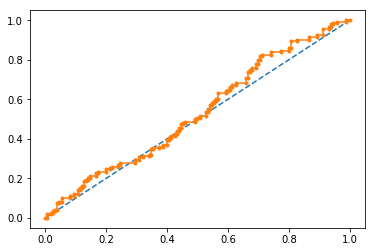

In [19]:
epoch_test_loss, epoch_test_score = validation_conv(model, device, valid_loader)

In [13]:
print("The score is {} ".format(epoch_test_score))

The score is 0.7133333333333334 


### This is for MesoNet on F2F

In [60]:
model_path = "/home/chinmay/model_weights/MesoNet_final/MesoNet80"
model_name_encoder ="meso_df_2_epoch61.pth" 
PATH = os.path.join(model_path, model_name_encoder)
model.load_state_dict(torch.load(PATH))

AUC: 0.713


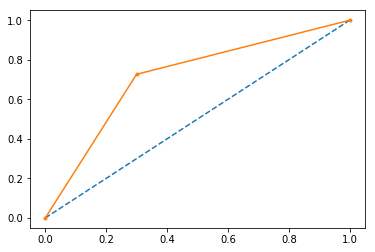

In [63]:
epoch_test_loss, epoch_test_score = validation_conv(model, device, valid_loader)

In [62]:
print("The score is {} ".format(epoch_test_score))

The score is 0.96 


### For Conv3D

# Now on DeepFake Dataset

In [17]:
val_path = '/home/chinmay/datatset/deepfake_split/val'
val_data = Dataset_CRNN_Deep_Fake(val_path, transform=TRANSFORM_IMG, frame_length=30)

In [18]:
deep_fake_valid_loader = data.DataLoader(val_data, **params)

In [69]:
epoch_test_loss, epoch_test_score = validation_conv(model, device, deep_fake_valid_loader)

In [70]:
print("The score is {} ".format(epoch_test_score))

The score is 0.8978723404255319 


In [38]:
model_path = "/home/chinmay/model_weights/MesoNet-df/MesoNet-dropout-40"
model_name_encoder ="meso_df_2_epoch28.pth" 
PATH = os.path.join(model_path, model_name_encoder)
model.load_state_dict(torch.load(PATH))

The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 30, 2])
The computed logit is shape torch.Size([16, 30, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 30, 2])
The computed logit is shape torch.Size([16, 30, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 30, 2])
The computed logit is shape torch.Size([16, 30, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 30, 2])
The computed logit is shape torch.Size([16, 30, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 30, 2])
The computed logit is shape torch.Size([16, 30, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 30, 2])
The computed logit is shape torch.Size([16, 30, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 30, 2])
The compu

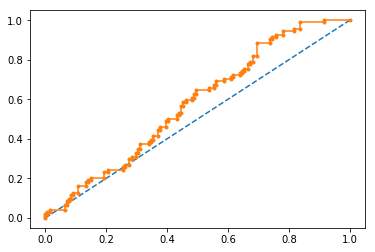

In [79]:
epoch_test_loss, epoch_test_score = validation_conv(model, device, deep_fake_valid_loader)

In [75]:
print("The score is {} ".format(epoch_test_score))

The score is 0.9702127659574468 


### This is for Res-CNN

In [76]:
epoch_test_loss, epoch_test_score = validation_res([cnn_encoder, rnn_decoder], device, deep_fake_valid_loader)


Test set (235 samples): Average loss: 0.3118, Accuracy: 89.36%



In [77]:
print("The score is {} ".format(epoch_test_score))

The score is 0.8936170212765957 


#  Combined Model

In [14]:
# reload CRNN model
cnn_encoder = ResCNNEncoder().to(device) #Since we have a GPU already
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_emded_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=2).to(device)

In [15]:
model_path = "/home/chinmay/model_weights/res_vgg_combined/"
model_name_encoder = "cnn_encoder_epoch10.pth"
PATH = os.path.join(model_path, model_name_encoder)
cnn_encoder.load_state_dict(torch.load(PATH))
model_name_decoder = "rnn_decoder_epoch10.pth"
PATH = os.path.join(model_path, model_name_decoder)
rnn_decoder.load_state_dict(torch.load(PATH))

The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 2])
The computed prob is shape torch.Size([16, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 2])
The computed prob is shape torch.Size([16, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 2])
The computed prob is shape torch.Size([16, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 2])
The computed prob is shape torch.Size([16, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 2])
The computed prob is shape torch.Size([16, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 2])
The computed prob is shape torch.Size([16, 1])
The expected output shape is torch.Size([16])
The computed prob is shape torch.Size([16, 2])
The computed prob is shape torch.Size([16, 1])
The expected output 

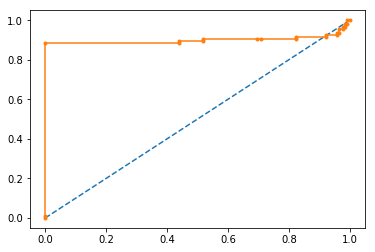

In [34]:
epoch_test_loss, epoch_test_score = validation_res([cnn_encoder, rnn_decoder], device, deep_fake_valid_loader)

In [ ]:
print("The score is {} ".format(epoch_test_score))

In [51]:
print('AUC: %.3f' % auc)

AUC: 0.000


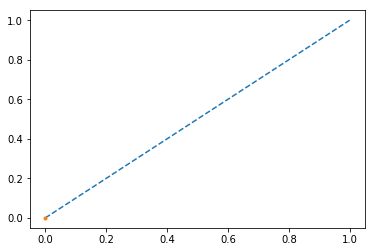

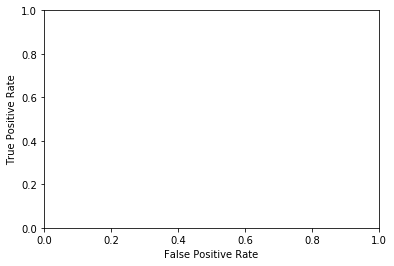

In [53]:
from matplotlib import pyplot
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
fpr = 0
tpr = 0
thresholds = 0
roc_auc = 0
auc = 0

In [14]:
epoch_test_loss, epoch_test_score = validation_res([cnn_encoder, rnn_decoder], device, valid_loader)


Test set (300 samples): Average loss: 3.0971, Accuracy: 50.33%



In [15]:
print("The score is {} ".format(epoch_test_score))

The score is 0.5033333333333333 
